In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Loading in each of the CSVs to visualize the data

# Actual price values (one per insntrument used per day)
df_vals = pd.read_csv("DailyStockFeed1.csv")
vals = df_vals.iloc[:,:].values
print("Stock Feed:\n",vals[vals[:,1].argsort()],"\n")

# Original performance (buying on up streak and not selling)
df_trans1 = pd.read_csv("ReverseMomentum1.csv")
trans1 = df_trans1.iloc[:,:].values
print("Transactions Record 1:\n", trans1[trans1[:,1].argsort()],"\n")

# Revision 1 performance (buying on down streak and not selling)
df_trans2 = pd.read_csv("ReverseMomentum2.csv")
trans2 = df_trans2.iloc[:,:].values
print("Transactions Record 2:\n", trans2[trans2[:,1].argsort()],"\n")

# Revision 2 performance (weird unexpected behavior)
df_trans3 = pd.read_csv("ReverseMomentum3.csv")
trans3 = df_trans3.iloc[:,:].values
trans3 = trans3[trans3[:,1].argsort()]
print("Transactions Record 3:\n", trans3,"\n")

# Revision 3 performance (buying in down streak and selling on up streak as intended)
df_trans4 = pd.read_csv("ReverseMomentum4.csv")
trans4 = df_trans4.iloc[:,:].values
trans4 = trans4[trans4[:,1].argsort()]
print("Transactions Record 4:\n", trans4,"\n")

Stock Feed:
 [['ACL' '2017-02-08 09:00:15' -62.0 9300]
 ['ADG' '2017-02-08 09:00:25' 180.0 5100]
 ['AAF' '2017-02-08 09:00:37' -31.0 3300]
 ..., 
 ['AAO' '2017-08-18 10:02:57' 101.44 8000]
 ['AAT' '2017-08-18 10:19:08' 99.77 7300]
 ['ADK' '2017-08-18 11:11:39' 109.84 7200]] 

Transactions Record 1:
 [[2 '2017-02-11 09:01:08' 'AAK' -6000 69.86]
 [3 '2017-02-11 09:16:38' 'ABP' -6000 82.73]
 [4 '2017-02-11 09:23:09' 'ADU' -6000 25.67]
 ..., 
 [661 '2017-08-18 12:00:00' 'ABA' 42000 56.52]
 [671 '2017-08-18 12:00:00' 'ABK' 24000 44.0]
 [735 '2017-08-18 12:00:00' 'ADV' 60000 27.56]] 

Transactions Record 2:
 [[2 '2017-02-11 09:01:51' 'ACP' -6000 73.75]
 [3 '2017-02-11 09:07:27' 'ADM' -6000 77.56]
 [4 '2017-02-11 09:08:01' 'AAV' -6000 28.7]
 ..., 
 [589 '2017-08-18 12:00:00' 'AAZ' 42000 27.73]
 [599 '2017-08-18 12:00:00' 'ABK' 30000 44.0]
 [663 '2017-08-18 12:00:00' 'ADV' 24000 27.56]] 

Transactions Record 3:
 [[2 '2017-02-08 00:00:00' 'AAB' 0 0.0]
 [74 '2017-02-08 00:00:00' 'ACV' 0 0.0]
 [7

In [3]:
def plot_prices_change(vals, trans, symbol, return_values = False):
    curr_vals = vals[vals[:,0] == symbol]
    curr_vals[:, 1] = [date[:10] for date in curr_vals[:, 1]]
    curr_trans = trans[trans[:,2] == symbol]
    curr_trans[:, 1] = [date[:10] for date in curr_trans[:, 1]]
    
    if not return_values:
        print("Transactions executed:")
        print(curr_trans)
    
    Dates = curr_vals[:,1]
    
    # Plot 1: Raw Price Movement
    Prices = curr_vals[:,2]
    
    # Plot 2: Change From Previous Day
    Changes = [1 if curr>=last else -1 
               for curr, last in zip(Prices, np.insert(Prices[:-1], 0, Prices[0]))]
    
    # Plot 3: Change Streaks
    Changes_scaled = []
    
    last_change = 0
    change_count = 0
    for change in Changes:
        if change == last_change:
            change_count += 1
            if change_count > 3:
                change_count = 1
            Changes_scaled.append(last_change * change_count)
        else:
            last_change = change
            change_count = 1
            Changes_scaled.append(0)
            
    #Plot 4 and 5: Current Holdings and Current Returns
    trans_pointer = 0
    Holdings = []
    curr_holdings = 0
    Returns = []
    curr_rets = 0
    Values = []
    curr_value = 0
    for date in Dates:
        if trans_pointer >= len(curr_trans):
            break
        while trans_pointer < len(curr_trans) and date == curr_trans[trans_pointer,1]:
            
            curr_holdings -= curr_trans[trans_pointer,3]
            curr_rets += (curr_trans[trans_pointer,3] 
                           * curr_trans[trans_pointer,4])
            curr_value = curr_holdings * curr_trans[trans_pointer,4]
            trans_pointer += 1
        Holdings.append(curr_holdings)
        Returns.append(curr_rets)
        Values.append(curr_value)
        
        
    if (not return_values):
        plt.close()
        fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(16,9), sharex=True)
        plt.subplots_adjust(wspace=0.0, hspace=0.4)

        ax[0].plot(Dates, Prices)
        ax[0].set_title("Raw Price Movement")
        ax[0].set_ylabel("Price")

        ax[1].plot(Dates, Changes)
        ax[1].set_title("Type of change on each day (1 = increase, -1 = decrease)")
        ax[1].set_ylabel("Change From Previous Day")

        ax[2].plot(Dates, Changes_scaled)
        ax[2].set_title("Change Streaks (Red = buy, green = sell)")
        ax[2].set_ylabel("Streak")
        ax[2].axhline(3, color='green')
        ax[2].axhline(-3, color='red')
        ax[2].set_yticks(range(-3,4))

        ax[3].plot(Dates, Holdings)
        ax[3].set_title("Current Holdings")
        
        ax[4].plot(Dates, Values)
        ax[4].set_title("Current Portfolio Value")

        ax[5].plot(Dates, Returns)
        ax[5].axhline(0, color='grey')
        ax[5].set_title("Current Returns (Amount invested (-) or returned(+))")

        ax[-1].set_xlabel("Day")
        ax[-1].set_xticklabels([])

        plt.show()
    else:
        return Returns, Values, Dates

Transactions executed:
[[47 '2017-02-23' 'AAA' -6000 27.42]
 [92 '2017-03-08' 'AAA' -6000 24.61]
 [238 '2017-04-26' 'AAA' -6000 30.0]
 [391 '2017-06-08' 'AAA' -6000 35.52]
 [457 '2017-06-28' 'AAA' -6000 35.52]
 [551 '2017-07-26' 'AAA' -6000 38.08]
 [617 '2017-08-10' 'AAA' -6000 42.72]
 [635 '2017-08-18' 'AAA' 42000 36.72]]


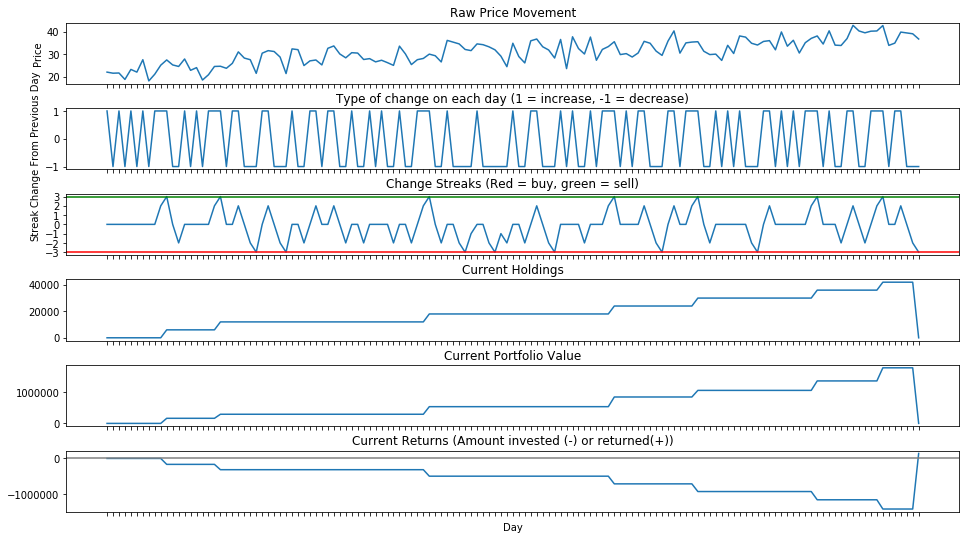

In [4]:
plot_prices_change(vals, trans1, 'AAA') 
# Run with no selling and buying at wrong time (on up streak)

Transactions executed:
[[104 '2017-03-16' 'AAA' -6000 21.45]
 [132 '2017-03-23' 'AAA' -6000 21.36]
 [267 '2017-05-04' 'AAA' -6000 32.08]
 [283 '2017-05-11' 'AAA' -6000 31.92]
 [287 '2017-05-13' 'AAA' -6000 24.41]
 [319 '2017-05-25' 'AAA' -6000 28.27]
 [384 '2017-06-20' 'AAA' -6000 29.44]
 [449 '2017-07-12' 'AAA' -6000 34.05]
 [560 '2017-08-18' 'AAA' -6000 36.72]
 [564 '2017-08-18' 'AAA' 54000 36.72]]


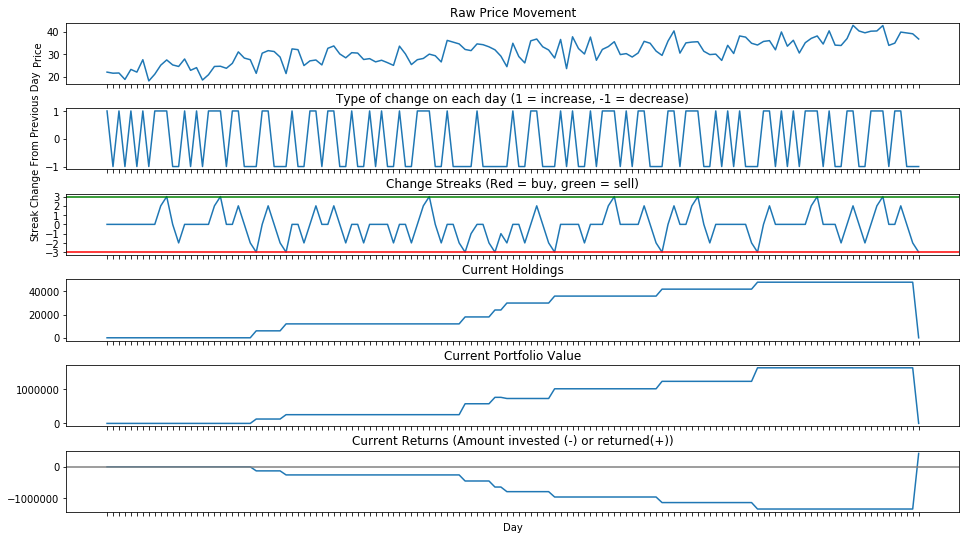

In [5]:
plot_prices_change(vals, trans2, 'AAA') 
# Run with no selling but corrected buying (on down streak)

Transactions executed:
[[728 '2017-04-20' 'AAA' -6000 30.08]
 [899 '2017-05-13' 'AAA' -6000 24.41]
 [1031 '2017-06-01' 'AAA' -6000 30.05]
 [1072 '2017-06-08' 'AAA' 6000 35.52]
 [540 '2017-06-13' 'AAA' -6000 28.72]
 [569 '2017-06-15' 'AAA' 6000 35.69]
 [1153 '2017-06-20' 'AAA' -6000 29.44]
 [613 '2017-06-22' 'AAA' 0 40.33]
 [639 '2017-06-27' 'AAA' 0 35.36]
 [1222 '2017-06-28' 'AAA' 6000 35.52]
 [1336 '2017-07-12' 'AAA' -6000 34.05]
 [1443 '2017-07-26' 'AAA' 6000 38.08]
 [943 '2017-08-08' 'AAA' 6000 40.2]
 [1591 '2017-08-10' 'AAA' 6000 42.72]
 [1639 '2017-08-18' 'AAA' -6000 36.72]
 [1646 '2017-08-18' 'AAA' 6000 36.72]]


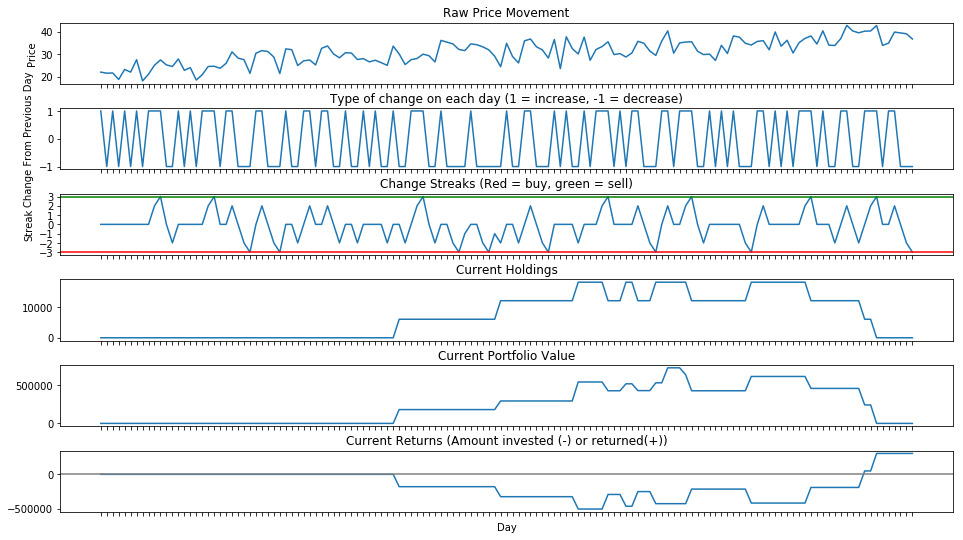

In [6]:
plot_prices_change(vals, trans3, 'AAA') 
# Something messed up in trying to fix selling and this happened

Transactions executed:
[[224 '2017-02-23' 'AAA' 0 27.42]
 [331 '2017-03-08' 'AAA' 0 24.61]
 [386 '2017-03-16' 'AAA' -6000 21.45]
 [446 '2017-03-23' 'AAA' -6000 21.36]
 [708 '2017-04-26' 'AAA' 6000 30.0]
 [771 '2017-05-04' 'AAA' -6000 32.08]
 [827 '2017-05-11' 'AAA' -6000 31.92]
 [841 '2017-05-13' 'AAA' -6000 24.41]
 [945 '2017-05-25' 'AAA' -6000 28.27]
 [1052 '2017-06-08' 'AAA' 6000 35.52]
 [1133 '2017-06-20' 'AAA' -6000 29.44]
 [1202 '2017-06-28' 'AAA' 6000 35.52]
 [1316 '2017-07-12' 'AAA' -6000 34.05]
 [1423 '2017-07-26' 'AAA' 6000 38.08]
 [1571 '2017-08-10' 'AAA' 6000 42.72]
 [1619 '2017-08-18' 'AAA' -6000 36.72]
 [1626 '2017-08-18' 'AAA' 24000 36.72]]


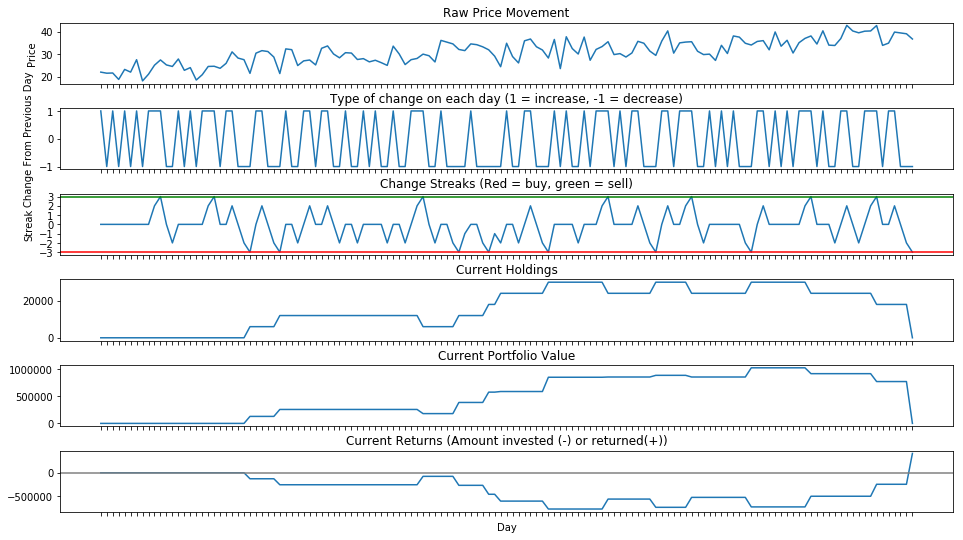

In [7]:
plot_prices_change(vals, trans4, 'AAA') 
# Correct buying (down streak) and selling (up streak) in increments of 6000

In [8]:
# Extracting the overall total returns and portfolio values over time

Dates = sorted(list(set([date[:10] for date in vals[:, 1]])))
instruments = set(trans4[:,2])

total_returns = [0]*len(Dates)
total_values = [0]*len(Dates)
for instrument in instruments:
    returns, values, dates = plot_prices_change(vals, trans4, instrument, True)
    for date, ret, val in zip(dates,returns, values):
        total_returns[Dates.index(date)] += ret
        total_values[Dates.index(date)] += val

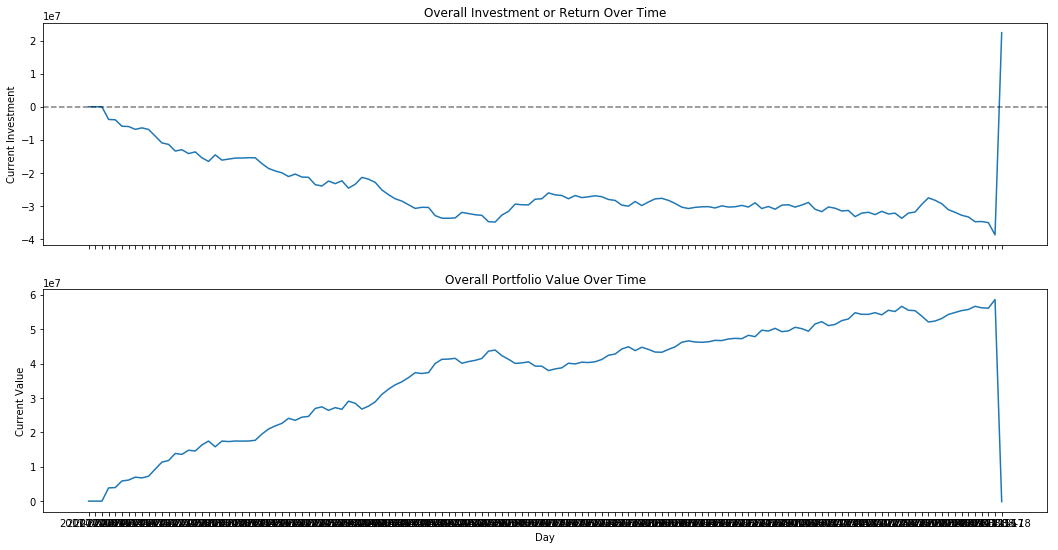

In [9]:
# Visualizing the overall total returns and portfolio values over time

plt.close()
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,9), sharex=True)

ax[0].plot(Dates, total_returns)
ax[0].set_title("Overall Investment or Return Over Time")
ax[0].axhline(0, color = "black", linestyle = "dashed", alpha = 0.5)
ax[0].set_ylabel("Current Investment")

ax[1].plot(Dates, total_values)
ax[1].set_title("Overall Portfolio Value Over Time")
ax[1].set_ylabel("Current Value")

ax[-1].set_xlabel("Day")
ax[-1].set_xticks(range(len(Dates)),())

plt.show()

In [11]:
# Extracting statistics from the data
buy_transactions = trans4[trans4[:,3] < 0]
amount_invested = -sum([volume * price for volume, price 
                        in zip(buy_transactions[:,3], buy_transactions[:,4])])
sell_transactions = trans4[trans4[:,3] > 0]
amount_returned = sum([volume * price for volume, price 
                       in zip(sell_transactions[:,3], sell_transactions[:,4])])
net_profit = amount_returned - amount_invested
return_on_investment = net_profit/amount_invested * 100

print("Reverse Momentum results:")
print("The algorithm suggested {} buy transactions which totaled in ${:,} invested."
      .format(len(buy_transactions), amount_invested))
print("The algorithm suggested {} sell transactions which totaled in ${:,} returned."
      .format(len(sell_transactions), amount_returned))
print("The net profit for this strategy over this time period was ${:,}"
      .format(net_profit))
print("with an ROI of {}%.".format(return_on_investment))

Reverse Momentum results:
The algorithm suggested 563 buy transactions which totaled in $186,661,260.0 invested.
The algorithm suggested 474 sell transactions which totaled in $217,322,700.0 returned.
The net profit for this strategy over this time period was $30,661,440.0
with an ROI of 16.426247203088632%.


## Discussion

### Reverse Momentum is a strategy that assumes that current market trends will reverse. As such, it proposes that  one should buy during a streak of decreasing price, anticipating an increase, and sell during a streak of increased price, anticipating a decrease. 

### The results above visualize the proposed transactions from an SQL implementation of this strategy. This implementation makes buy and sell decisions upon a three day streak of increase and decrease, respectively, for each instrument observed and resets the streak to 1 or -1, respectively, following a transaction proposal. It was tested on six months of data generated using the sample code provided. One hundred instruments were used in this test.

### Based on the outcomes shown above, the strategy was successful in producing a favorable result with an ROI of 16.43 % and a Net Profit of \$30661440. The majority of this return happened at the end of the time period, as seen above in the graph titled "Overall Investment or Return Over Time", as a result of the net profit calculations at the end of the period. Comparing this to the results we have for the standard and simpler Buy and Hold strategy of a ROI 6.92 % and a Net Profit of $30,153, the Reverse Momentum strategy shows remarkably better results with either measure. 

### The program required a bit of work to get running correctly, which was difficult since it would have to be run for over an hour and the results analyzed manually to find issues with the algorithm. Shown above are four iterations on the program and their results. The final iteration, whose code is provided below, was ultimately able to buy and sell at the respective three day streak.

In [ ]:
BEGIN

-- variables for DailyStockFeed table
DECLARE this_trading_symbol varchar(15);
DECLARE this_trade_time datetime;
DECLARE this_trade_price decimal(18,4);
DECLARE this_trade_size int(11);

DECLARE sum_stocks int(11);

-- loop count variables
DECLARE loopcount int(11);
DECLARE maxloops int(11);

-- EOP variable
DECLARE db_done int default false;

-- declare cursor
DECLARE cur1 CURSOR FOR SELECT TRADING_SYMBOL, TRADE_TIME, TRADE_PRICE, TRADE_SIZE FROM F17336Pteam6.DailyStockFeed ORDER BY TRADE_TIME;

DECLARE continue handler for not found SET db_done=1;
SET maxloops = loops * 1000;
SET loopcount = 0;

-- initialize the streak table
TRUNCATE TABLE TempStockStreak2;

INSERT INTO F17336Pteam6.TempStockStreak2 (SYMBOL, THIS_TIME, CURRENT_PRICE, STREAK)
SELECT TRADE_SYMBOL, TRADE_TIME, TRADE_PRICE, 0
FROM
    (SELECT *
        FROM F17336Pteam6.STOCK_TRADE_FEED
        GROUP BY TRADE_SYMBOL) as FEED;

/* live feed simulation */
open cur1;
   quote_loop: LOOP
        if (db_done OR loopcount >= maxloops) then leave quote_loop;
        end if;

        fetch cur1 into this_trading_symbol, this_trade_time, this_trade_price, this_trade_size;

        -- if the price increased since the last check
        if (SELECT CURRENT_PRICE
            FROM F17336Pteam6.TempStockStreak2
            WHERE SYMBOL = this_trading_symbol) <= this_trade_price then
            -- if the stock is on a positive streak, increment its streak by 1
            if (SELECT STREAK
                FROM F17336Pteam6.TempStockStreak2
                WHERE SYMBOL = this_trading_symbol) >= 0 then
                UPDATE F17336Pteam6.TempStockStreak2 SET STREAK = STREAK + 1
                WHERE SYMBOL = this_trading_symbol;

            -- if the stock is on a negative streak, change it so it's on a positive streak
            else
                UPDATE F17336Pteam6.TempStockStreak2 SET STREAK = 1
                WHERE SYMBOL = this_trading_symbol;
            end if;

        -- if the price decreased since the last check
        else
            -- if the stock is on a positive streak, change it so it's on a negative streak
            if (SELECT STREAK
                FROM F17336Pteam6.TempStockStreak2
                WHERE SYMBOL = this_trading_symbol) >= 0
            then
                UPDATE F17336Pteam6.TempStockStreak2 SET STREAK = -1
                WHERE SYMBOL = this_trading_symbol;

            -- if the stock is on a negative streak, decrement it by 1
            else
                UPDATE F17336Pteam6.TempStockStreak2 SET STREAK = STREAK - 1
                WHERE SYMBOL = this_trading_symbol;
            end if;
        end if;

        -- always update the current price and current time
        UPDATE F17336Pteam6.TempStockStreak2 SET CURRENT_PRICE = this_trade_price,
        THIS_TIME = this_trade_time
        WHERE SYMBOL = this_trading_symbol;

 	if (SELECT STREAK
            FROM F17336Pteam6.TempStockStreak2
                WHERE SYMBOL = this_trading_symbol) >= 3
        then
            SET sum_stocks = (SELECT SUM(QUANTITY) FROM F17336Pteam6.ReverseMomentum WHERE TRADE_SYMBOL = this_trading_symbol) * -1;
	    
                -- sell stocks by adding it to the ReverseMomentum table
            INSERT INTO F17336Pteam6.ReverseMomentum (TRADE_TIME, TRADE_SYMBOL, QUANTITY, PRICE)
            VALUES (this_trade_time, this_trading_symbol, LEAST(sum_stocks,  6000)
, this_trade_price);
                    
        -- after updating the stocks, check the streak
        -- if streak <= -3, we should buy 6k shares of stocks and reset the streak to -1 
        -- so we don't continuously buy stocks every single time
        elseif (SELECT STREAK
            FROM F17336Pteam6.TempStockStreak2
                WHERE SYMBOL = this_trading_symbol) <= -3
        then
            -- buy stocks by adding it to ReverseMomentum table
            INSERT INTO F17336Pteam6.ReverseMomentum (TRADE_TIME, TRADE_SYMBOL, QUANTITY, PRICE)
            VALUES (this_trade_time, this_trading_symbol, -6000, this_trade_price);

            -- reset the streak
            UPDATE F17336Pteam6.TempStockStreak2 SET STREAK = -1
            WHERE SYMBOL = this_trading_symbol;


end if;

        set loopcount = loopcount + 1;
        END LOOP;

close cur1;

END